In [39]:
import os
import gc
import sys
import json
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import cv2 as cv

import torch
from lvis import LVIS
from torchvision.transforms import transforms
from torchvision.utils import (
    draw_bounding_boxes, 
    draw_segmentation_masks
)

import warnings
warnings.filterwarnings("ignore")

In [40]:
sys.path.append(os.path.join(os.getcwd(), "sam", "segment_anything"))
sys.path.append(os.path.join(os.getcwd(), "sam_hq", "segment_anything"))

from sam.segment_anything import (
    sam_model_registry, 
    SamPredictor
)
from sam_hq.segment_anything import (
    sam_model_registry as sam_hq_model_registry, 
    SamPredictor as SamHQPredictor
)

----

# Preliminary phase

#### EgoObjects is annotated in a LVIS-like style but the metadata (cateogries ids) is provided in a different file. If necessary, we merge the two files to have a single file with all the information.

In [41]:
def append_categories(path_1, path_2, outPath):
    with open(path_1, "r") as f:
        eval = json.load(f)
    with open(path_2, "r") as f:
        metadata = json.load(f)

    eval["categories"] = metadata["categories"]
    with open(outPath, "w") as f:
        json.dump(eval, f)

In [42]:
def preprocess(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    for i in range(len(data["annotations"])):
        data["annotations"][i]["category_id"] = data["annotations"][i]["_category_id"]
    with open(json_path, "w") as f:
        json.dump(data, f)

In [43]:
dataPath = os.path.join(os.getcwd(), "data", "EgoObjects")
imgPath = os.path.join(dataPath, "images")

In [44]:
evalPath = os.path.join(dataPath, "ego_objects_eval.json")
categoriesPath = os.path.join(dataPath, "ego_objects_metadata.json")
outPath = os.path.join(dataPath, "ego_objects_eval_all.json")

if not os.path.exists(outPath):
    append_categories(evalPath, categoriesPath, outPath)
    preprocess(outPath)

In [45]:
lvis = LVIS(outPath)

----

# Qualitative EDA of images

In [46]:
if not os.path.exists("Verdana.ttf"):
    os.system("wget https://github.com/matomo-org/travis-scripts/raw/master/fonts/Verdana.ttf")

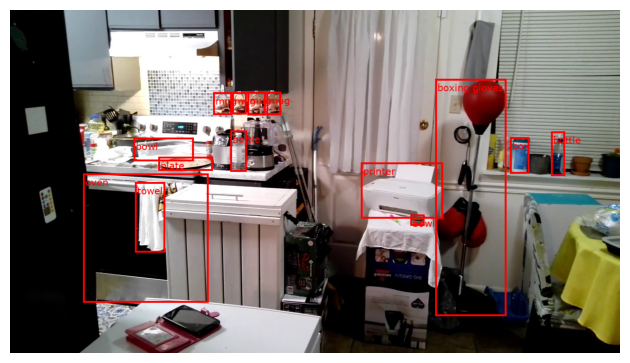

In [47]:
img_ids = lvis.imgs.keys()
img_ids = sorted(img_ids, key=lambda x: random.random())

for img_id in img_ids:
    ann_ids = lvis.get_ann_ids(img_ids = [img_id])
    target = lvis.load_anns(ann_ids)

    path = lvis.load_imgs([img_id])[0]
    path = str(path["group_id"]) + "_" + str(path["video_id"]) + "_" + str(path["frame_id"]) + ".jpg"

    img = cv.imread(os.path.join(imgPath, path))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    toShow = transforms.ToTensor()(img) * 255
    toShow = toShow.type(torch.uint8)

    nums = len(target)
    boxes, labels = [], []
    for i in range(nums):
        x, y, w, h = target[i]['bbox']
        boxes.append([int(x), int(y), int(x + w), int(y + h)])
        label_id = target[i]['category_id']
        label = lvis.cats[label_id]['name']
        labels.append(label)
    boxes = torch.tensor(boxes).type(torch.int64)

    final_img = draw_bounding_boxes(toShow, boxes, labels, colors="red", width=4, font="Verdana.ttf", font_size=20)
    final_img = final_img.permute(1, 2, 0)
    plt.imshow(final_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

----

# Useful functions for visualization

In [48]:
def predictMasks(image, boxes, predictor):
    sam_boxes = predictor.transform.apply_boxes_torch(boxes, image.shape[:2])

    predictor.set_image(image)
    masks, *_ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=sam_boxes,
        multimask_output=False
    )
    return masks

In [49]:
def showMasks(image, masks):
    colors = list(mcolors.CSS4_COLORS.values())
    colors = random.sample(colors, len(masks))

    masks = masks.reshape(-1, *image.shape[:2])
    mask_img = transforms.ToTensor()(image)
    for i, mask in enumerate(masks):
        mask_img = draw_segmentation_masks(mask_img, mask.unsqueeze(0), colors=colors[i], alpha=0.8)
    mask_img = mask_img.permute(1, 2, 0)
    plt.imshow(mask_img)
    plt.axis('off')
    plt.show()

    return mask_img

In [50]:
def predict(img, boxes, predictor):
    boxes = boxes.to(predictor.device)
    masks = predictMasks(img, boxes, predictor)
    maskImg = showMasks(img, masks)
    return maskImg

---

# Load SAM

In [51]:
sam = sam_model_registry["vit_h"](checkpoint=os.path.join(os.getcwd(), "sam-checkpoints", "sam_vit_h.pth"))
sam.to(torch.device("cuda"))
sam_predictor = SamPredictor(sam)

--- 

# Bounding box input prompts

#### We will use the annotated bounding box as a prompt for SAM (and also for SAM-HQ down below). 

Each bounding box is treated as a prompt 

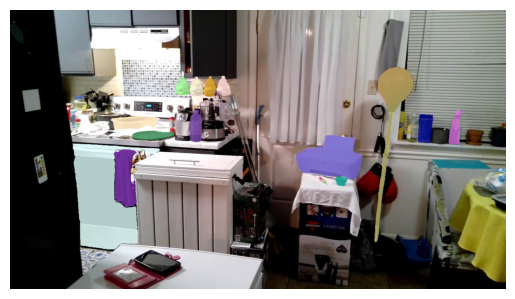

In [52]:
image = cv.imread(os.path.join(imgPath, path))
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
sam_mask_img = predict(image, boxes, sam_predictor)

In [53]:
# Here just for memory reason....

sam.cpu()
del sam, sam_predictor

gc.collect()
torch.cuda.empty_cache()

----

# Load SAM-HQ

In [54]:
samhq = sam_hq_model_registry["vit_h"](checkpoint=os.path.join(os.getcwd(), "sam-checkpoints", "sam_hq_vit_h.pth"))
samhq.to(torch.device("cuda"))
samhq_predictor = SamHQPredictor(samhq)

<All keys matched successfully>


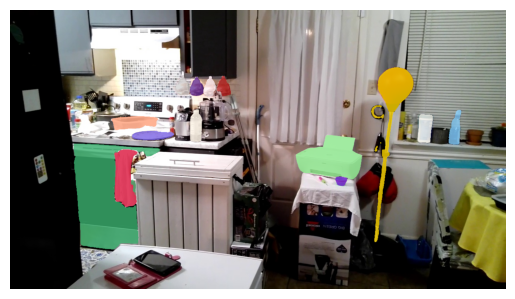

In [55]:
image = cv.imread(os.path.join(imgPath, path))
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
samhq_mask_img = predict(image, boxes, samhq_predictor)

In [56]:
# Here just for memory reason....
samhq.cpu()
del samhq, samhq_predictor

gc.collect()
torch.cuda.empty_cache()

----

# Direct Comparison

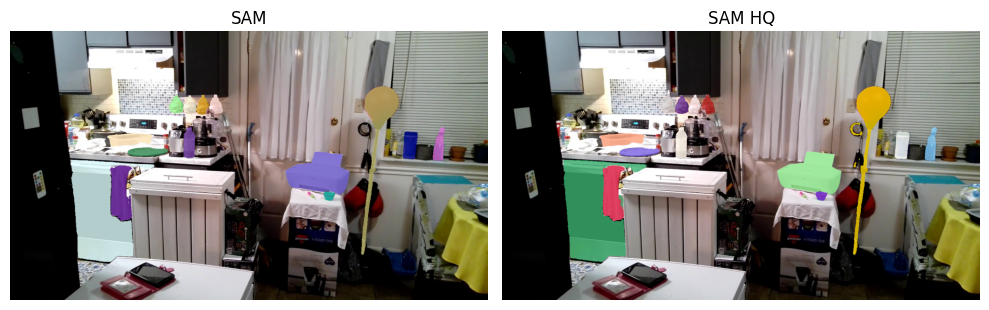

In [57]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(sam_mask_img)
plt.axis('off')
plt.title("SAM")

plt.subplot(1, 2, 2)
plt.imshow(samhq_mask_img)
plt.axis('off')
plt.title("SAM HQ")

plt.tight_layout()
plt.show()